In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import  balanced_accuracy_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def visualize_data_hist(df):
    num_cols = 7
    num_rows = math.ceil(len(df.columns) / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(24, 7))

    if num_rows == 1:
        axs = axs.reshape(1, -1)
    else:
        axs = axs.flatten()

    for i, column in enumerate(df.columns):
        axs[i].hist(df[column], bins=25, cumulative=False, density=True, color='green', alpha=0.5)
        axs[i].set_title(f'Distribution of {column}')
        axs[i].set_xlabel(column)
        axs[i].set_ylabel('Density')
        axs[i].grid(True, linestyle='--', linewidth=0.2)
        axs[i].tick_params(axis='x', rotation=0) 
        
        sorted_data = np.sort(df[column])
        n = sorted_data.size
        cumulative = np.arange(1, n + 1) / n
        ax2 = axs[i].twinx()
        ax2.plot(sorted_data, cumulative, color='blue', linestyle='-', linewidth=0.8)
        ax2.tick_params(axis='y')
        ax2.set_ylim(0, 1)
        ax2.grid(False)

    plt.tight_layout(pad=3.0)
    plt.show()

def scale_data(df, scaler):
    scaler = scaler
    numerical_features = df.select_dtypes(include=['int', 'float']).columns
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
    plt.title('Correlation Matrix of Features')
    plt.show()

def visualize_data_scatter(df, target):
    selected_columns = df.columns  

    num_plots = len(selected_columns)
    num_cols = 2  
    num_rows = (num_plots - 1) // num_cols + 1 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

    if num_rows == 1:
        axes = axes.reshape(1, -1)

    for i, column in enumerate(selected_columns):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].scatter(df[column], df[target], alpha=0.25, color='blue')
        axes[row, col].set_title(f'Scatter Plot of {column} vs {target}')
        axes[row, col].set_xlabel(column)
        axes[row, col].set_ylabel(target)
        axes[row, col].grid(True)

    plt.tight_layout()
    plt.show()

def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1

    threshold = 1

    outliers = ((df < (Q1 - threshold * IQR)) | (df > (Q3 + threshold * IQR))).any(axis=1)

    df_clean = df[~outliers]

    df_clean.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(12, 3))

    plt.subplot(1, 2, 1)
    plt.title('Boxplot Before Removing Outliers')
    df.boxplot(rot=45)

    plt.subplot(1, 2, 2)
    plt.title('Boxplot After Removing Outliers')
    df_clean.boxplot(rot=45)

    plt.tight_layout()
    plt.show()

def remove_least_correlated(df, target):
    correlation_with_output = df.corr()[target].abs().sort_values(ascending=False)

    correlation_with_output = correlation_with_output.drop(target)

    threshold = 0.1
    least_correlated_columns = correlation_with_output[correlation_with_output < threshold].index

    df_filtered = df.drop(least_correlated_columns, axis=1)

    print("Removed columns with correlation less than", threshold, "with", target,":\n", list(least_correlated_columns))

    return df_filtered

def traintest_split(df, target):
    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, y_train, X_test, y_test 

def plot_balanced_split(y, y_train, y_test):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ticks = [0, 1]
    bar_colors = ['green', 'red'] 

    axes[0].bar(y.value_counts().index, y.value_counts(normalize=True),color=bar_colors)
    axes[0].set_title('Original Class Distribution')
    axes[0].set_xticks(ticks)
    axes[0].set_xticklabels(ticks)
    axes[0].set_ylabel('Proportion')

    axes[1].bar(y_train.value_counts().index, y_train.value_counts(normalize=True),color=bar_colors)
    axes[1].set_title('Training Set Class Distribution')
    axes[1].set_xticks(ticks)
    axes[1].set_xticklabels(ticks)
    axes[1].set_ylabel('Proportion')

    axes[2].bar(y_test.value_counts().index, y_test.value_counts(normalize=True),color=bar_colors)
    axes[2].set_title('Testing Set Class Distribution')
    axes[2].set_xticks(ticks)
    axes[2].set_xticklabels(ticks)
    axes[2].set_ylabel('Proportion')

    for ax in axes:
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height /2),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        color='white', fontsize=20)

    plt.tight_layout()
    plt.show()

def K_Fold_CV(X_train, y_train, classifiers):
    n_splits = 5

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    avg_accuracies = {}
    accuracy_scores_all = {name: [] for name in classifiers.keys()}

    for name, classifier in classifiers.items():
        print("-"*42)
        accuracy_scores = []  
        print(f"Evaluating {name}:")
        for fold, (train_index, test_index) in enumerate(kf.split(X_train), 1):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
            
            classifier.fit(X_train_fold, y_train_fold)
            y_pred = classifier.predict(X_test_fold)
            
            accuracy = balanced_accuracy_score(y_test_fold, y_pred)
            accuracy_scores.append(accuracy)
            accuracy_scores_all[name].append(accuracy)

            
            print(f"Fold {fold}: \tAccuracy = {(accuracy * 100):.2f}%")
        
        avg_accuracy = sum(accuracy_scores) / n_splits
        avg_accuracies[name] = avg_accuracy
        
        print(f"\nAverage balanced accuracy for {name} = {(avg_accuracy * 100):.2f}%\n")
        

    plt.figure(figsize=(15, 5))
    for name, accuracies in accuracy_scores_all.items():
        plt.plot(np.arange(1, n_splits + 1), accuracies, label=name)



    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Balanced Accuracy of Different Models across Folds')
    plt.legend()
    plt.grid(True)
    plt.show()

def grid_search_cv(X_train, y_train, classifiers, param_grids):
    best_estimators = {}

    for name, classifier in classifiers.items():
        print("-"*100)
        print(f"Tuning hyperparameters for {name}:")
        
        pipeline = Pipeline([
            ("classifier", classifier)
        ])
        
        param_grid = param_grids[name]
        
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_estimators[name] = grid_search.best_estimator_
        
        print("Best Parameters:", grid_search.best_params_)
        print("Best Score:", grid_search.best_score_)

    return best_estimators

def evaluate_models(X_train, y_train, X_test, y_test, balanced_metrics, best_estimators):
    for name, estimator in best_estimators.items():

        pipeline = make_pipeline(StandardScaler(), estimator) if name != "Decision Tree" and name != "KNN" else estimator
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        metrics = {}
        for metric_name, metric_func in balanced_metrics.items():
            metric_value = metric_func(y_test, y_pred)
            metrics[metric_name] = metric_value
        
        print(f"Classifier:\t\t\t{name}")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}:\t\t{metric_value:.4f}")

        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        print("----------------------------------------------------")

In [3]:
df = load_data('medical_heart.csv')

df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.shape

(303, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64


In [7]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


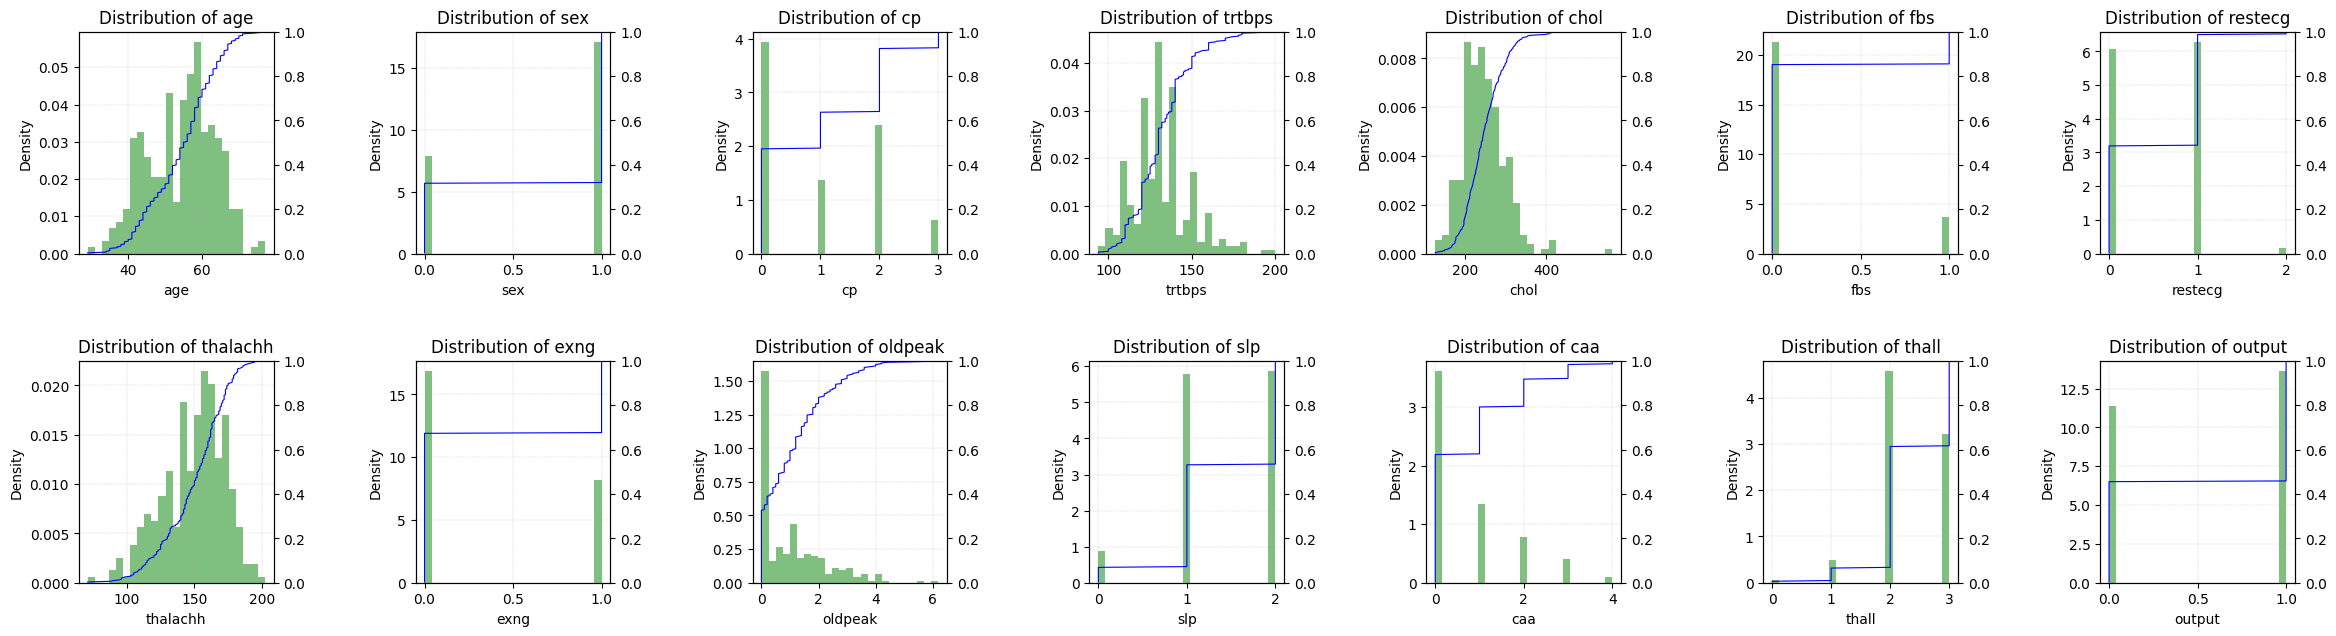

In [8]:
visualize_data_hist(df)

In [9]:
scale_data(df, MinMaxScaler())

In [10]:
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.00,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.00,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.00,0.666667,1.0
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.00,0.666667,1.0
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.00,0.666667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.583333,0.0,0.000000,0.433962,0.262557,0.0,0.5,0.396947,1.0,0.032258,0.5,0.00,1.000000,0.0
299,0.333333,1.0,1.000000,0.150943,0.315068,0.0,0.5,0.465649,0.0,0.193548,0.5,0.00,1.000000,0.0
300,0.812500,1.0,0.000000,0.471698,0.152968,1.0,0.5,0.534351,0.0,0.548387,0.5,0.50,1.000000,0.0
301,0.583333,1.0,0.000000,0.339623,0.011416,0.0,0.5,0.335878,1.0,0.193548,0.5,0.25,1.000000,0.0


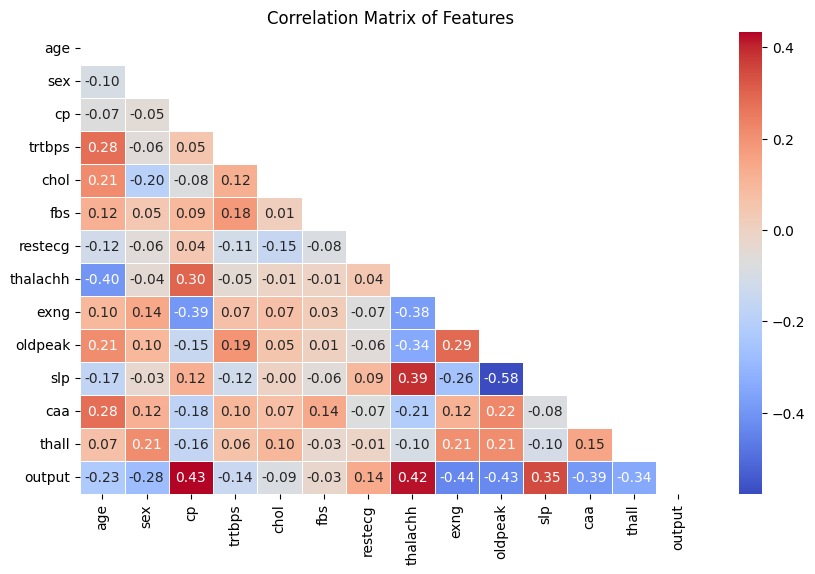

In [11]:
plot_correlation_matrix(df)


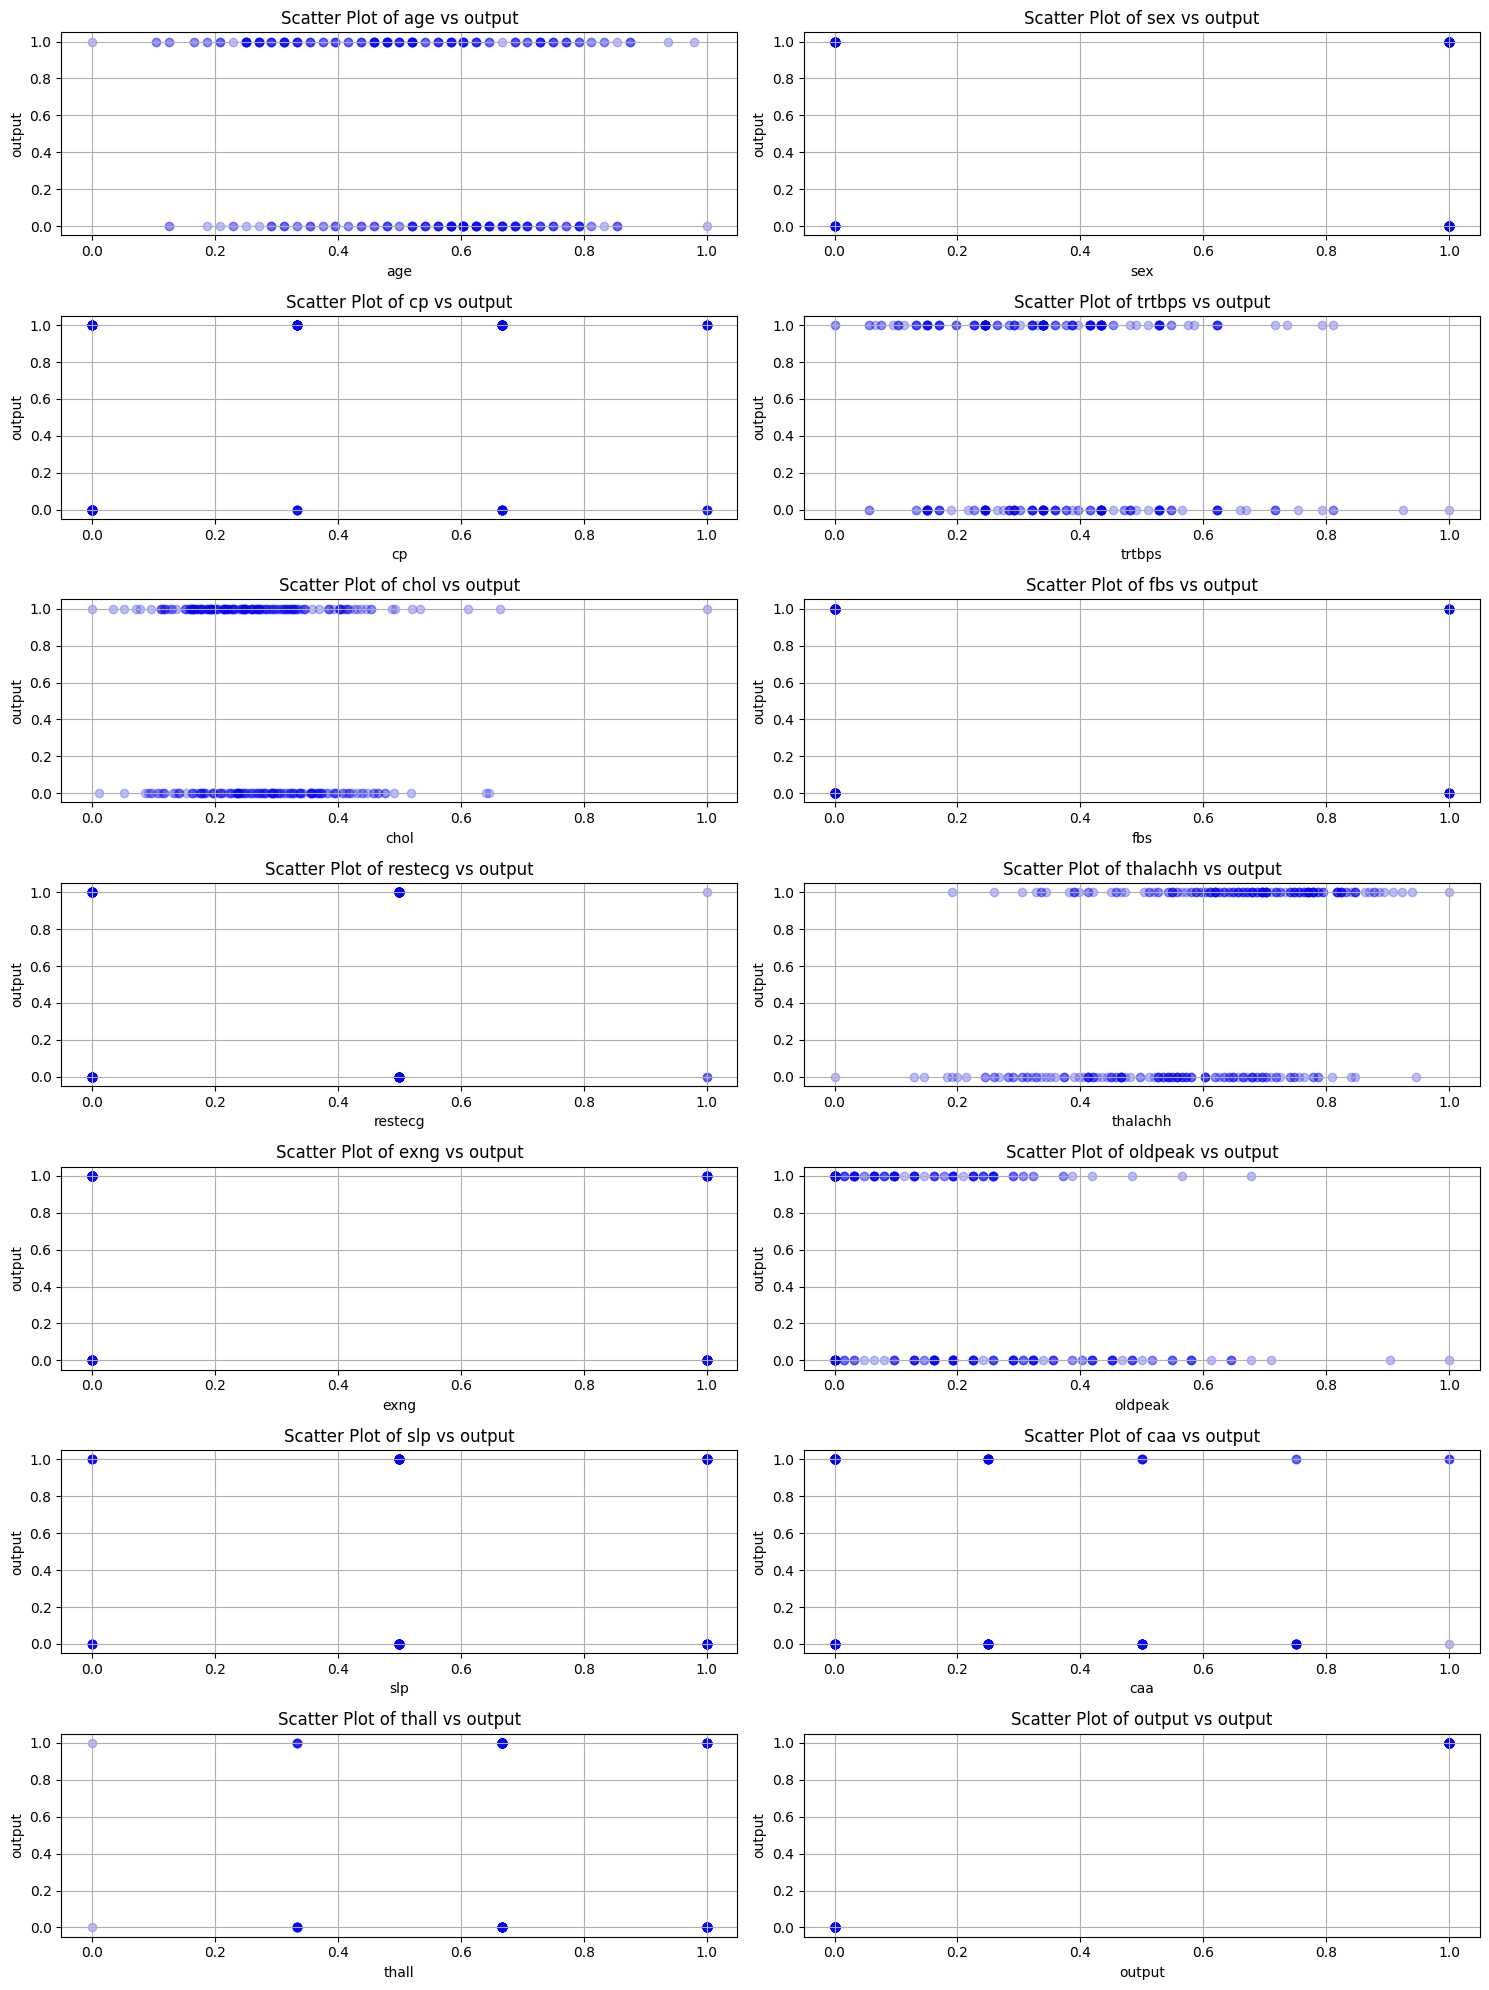

In [12]:
visualize_data_scatter(df, 'output')

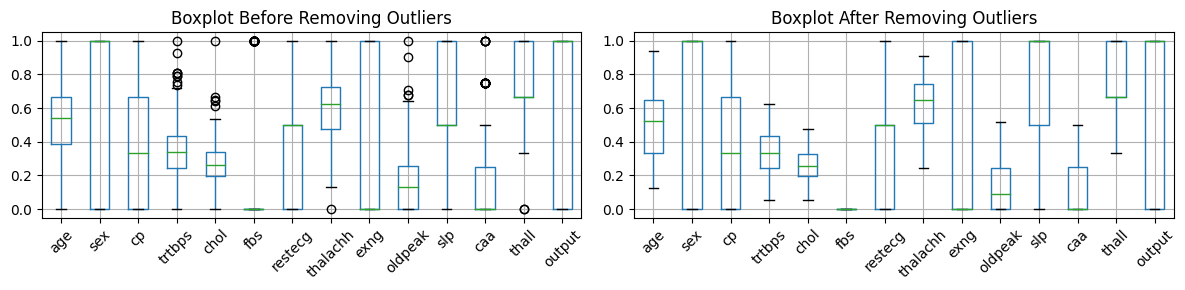

In [13]:
remove_outliers(df)

In [14]:
df = remove_least_correlated(df, 'output')

Removed columns with correlation less than 0.1 with output :
 ['chol', 'fbs']


In [15]:
X_train, y_train, X_test, y_test = traintest_split(df, 'output')

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (242, 11)
Shape of X_test: (61, 11)
Shape of y_train: (242,)
Shape of y_test: (61,)


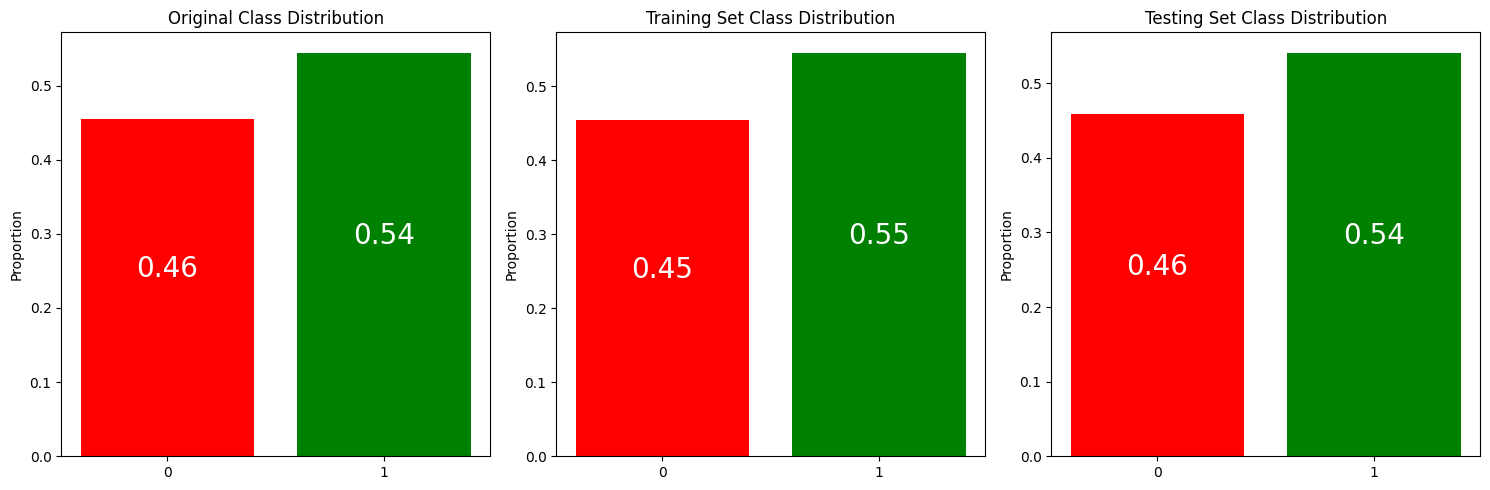

In [16]:
plot_balanced_split(df['output'], y_train, y_test)

In [17]:
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "KNN": KNeighborsClassifier()
}

------------------------------------------
Evaluating Logistic Regression:
Fold 1: 	Accuracy = 82.65%
Fold 2: 	Accuracy = 87.46%
Fold 3: 	Accuracy = 78.78%
Fold 4: 	Accuracy = 81.43%
Fold 5: 	Accuracy = 78.84%

Average balanced accuracy for Logistic Regression = 81.83%

------------------------------------------
Evaluating Decision Tree:
Fold 1: 	Accuracy = 75.98%
Fold 2: 	Accuracy = 81.44%
Fold 3: 	Accuracy = 79.48%
Fold 4: 	Accuracy = 75.71%
Fold 5: 	Accuracy = 73.28%

Average balanced accuracy for Decision Tree = 77.18%

------------------------------------------
Evaluating Random Forest:
Fold 1: 	Accuracy = 84.12%
Fold 2: 	Accuracy = 91.56%
Fold 3: 	Accuracy = 81.13%
Fold 4: 	Accuracy = 77.14%
Fold 5: 	Accuracy = 79.89%

Average balanced accuracy for Random Forest = 82.77%

------------------------------------------
Evaluating SVC:
Fold 1: 	Accuracy = 85.59%
Fold 2: 	Accuracy = 91.30%
Fold 3: 	Accuracy = 82.78%
Fold 4: 	Accuracy = 77.14%
Fold 5: 	Accuracy = 76.46%

Average balanced

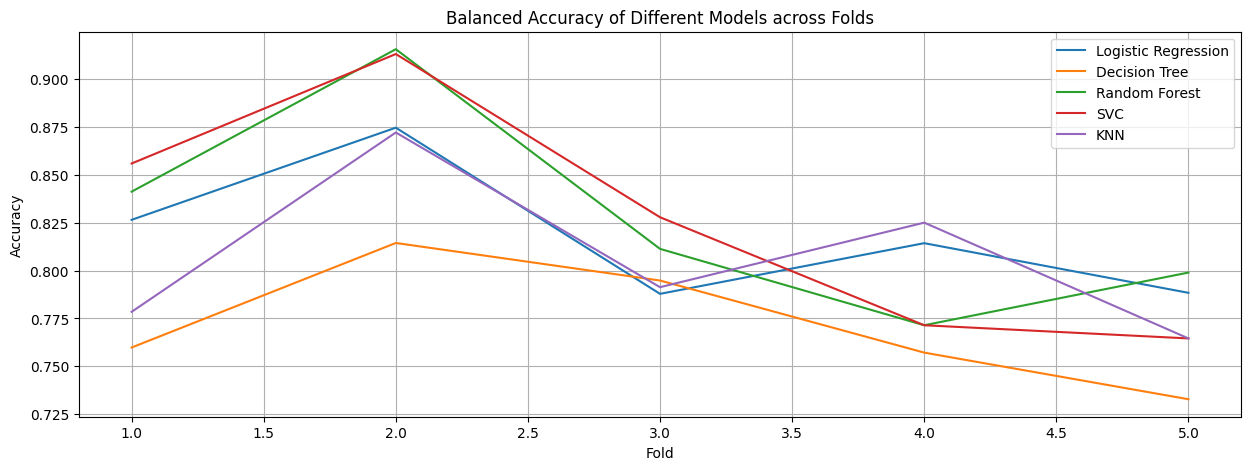

In [18]:
K_Fold_CV(X_train, y_train, classifiers)

In [19]:
param_grids = {
    "Logistic Regression": {
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": [0.01, 0.1, 1, 10]
    },
    "Decision Tree": {
        "classifier__max_depth": [None, 5, 10, 15],
        "classifier__min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "classifier__n_estimators": [100, 200, 400],
        "classifier__max_depth": [None, 5, 10],
        "classifier__min_samples_split": [2, 5, 10, 20]
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10, 100],
        "classifier__kernel": ["linear", "rbf"]
    },
    "KNN": {
        "classifier__n_neighbors": [3, 5, 7, 9],
        "classifier__weights": ["uniform", "distance"]
    }
}

best_estimators = grid_search_cv(X_train, y_train, classifiers, param_grids)

----------------------------------------------------------------------------------------------------
Tuning hyperparameters for Logistic Regression:
Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Best Score: 0.8227891156462585
----------------------------------------------------------------------------------------------------
Tuning hyperparameters for Decision Tree:
Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
Best Score: 0.7608843537414965
----------------------------------------------------------------------------------------------------
Tuning hyperparameters for Random Forest:
Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 20, 'classifier__n_estimators': 400}
Best Score: 0.8475340136054422
----------------------------------------------------------------------------------------------------
Tuning hyperparameters for SVC:
Best Parameters: {'classifier__C': 10, 'classifier__kernel': 'linear'}
Bes

Classifier:			Logistic Regression
Balanced Accuracy:		0.7911
F1 Score (weighted):		0.7975
Matthews Corr. Coeff.:		0.6181


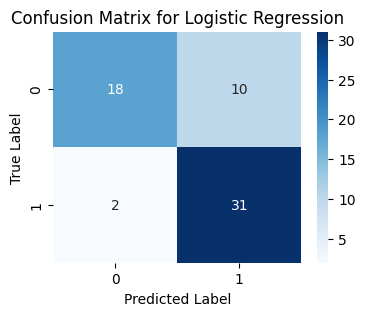

----------------------------------------------------
Classifier:			Decision Tree
Balanced Accuracy:		0.7430
F1 Score (weighted):		0.7483
Matthews Corr. Coeff.:		0.5096


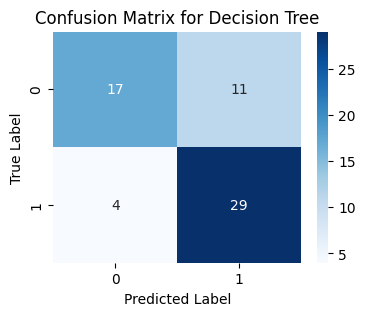

----------------------------------------------------
Classifier:			Random Forest
Balanced Accuracy:		0.8420
F1 Score (weighted):		0.8490
Matthews Corr. Coeff.:		0.7174


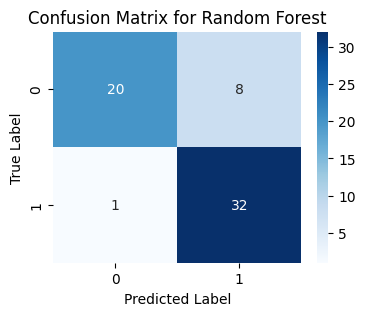

----------------------------------------------------
Classifier:			SVC
Balanced Accuracy:		0.7911
F1 Score (weighted):		0.7975
Matthews Corr. Coeff.:		0.6181


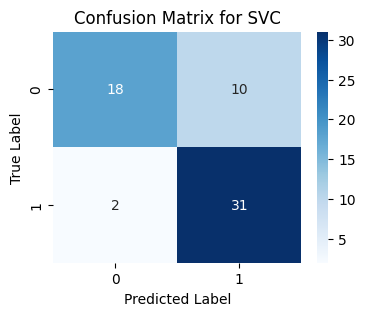

----------------------------------------------------
Classifier:			KNN
Balanced Accuracy:		0.8323
F1 Score (weighted):		0.8354
Matthews Corr. Coeff.:		0.6696


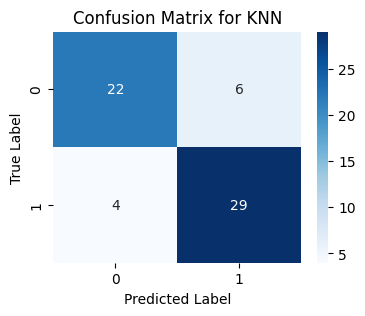

----------------------------------------------------


In [20]:
balanced_metrics = {
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Score (weighted)": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    "Matthews Corr. Coeff.": matthews_corrcoef
}

evaluate_models(X_train, y_train, X_test, y_test, balanced_metrics, best_estimators)